In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 6)
from IPython import display

Import modules:

In [2]:
import pynn as nn
import pynnui as nnui
import math
from random import random, shuffle
from copy import copy
import numpy as np
from matplotlib import pyplot as plt

Char to index and back conversion:

In [3]:
def idx(c):
    a = ord(c)
    if a >= 0x61 and a <= 0x7A:
        return a - 0x61
    if a == 0x27: # '
        return 0x1A
    if a == 0x2D: # -
        return 0x1B
    if a == 0xA:  # CR
        return 0x1C
    return -1

def char(i):
    if i >= 0 and i <= 0x19:
        return chr(i + 0x61)
    if a == 0x1A: # '
        return chr(0x27)
    if a == 0x1B: # -
        return chr(0x2D)
    if a == 0x1C: # CR
        return chr(0xA)
    return ''

Define network structure:

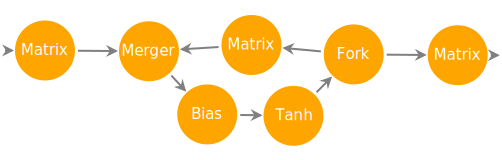

In [8]:
net = nn.Network(1, 1)
size = 0x1D
shid = 0x80

net.nodes[0] = nn.MatrixProduct(size, shid) # W_xh
net.nodes[1] = nn.MatrixProduct(shid, shid) # W_hh
net.nodes[2] = nn.Merger(shid, 2)
net.nodes[3] = nn.Bias(shid)
net.nodes[4] = nn.Tanh(shid)
net.nodes[5] = nn.Fork(shid, 2)
net.nodes[6] = nn.MatrixProduct(shid, size) # W_hy

net.paths.append(nn.Path((-1, 0), ( 0, 0)))
net.paths.append(nn.Path(( 0, 0), ( 2, 0)))
net.paths.append(nn.Path(( 1, 0), ( 2, 1)))

net.paths.append(nn.Path(( 2, 0), ( 3, 0)))
net.paths.append(nn.Path(( 3, 0), ( 4, 0)))
net.paths.append(nn.Path(( 4, 0), ( 5, 0)))

net.paths.append(nn.Path(( 5, 1), ( 1, 0)))
net.paths.append(nn.Path(( 5, 0), ( 6, 0)))
net.paths.append(nn.Path(( 6, 0), (-1, 0)))

net.update()

display.SVG(data=nnui.Graph(net).svg())

In [6]:
batch_size = 20

file = open('data/20k.txt')
words = []
for word in file:
    words.append(word)

del words[1000:]

epoch: 49
cost: 6.077302


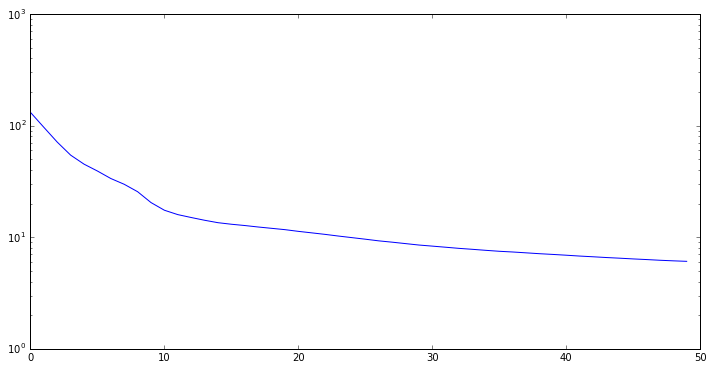

''

In [9]:
costs = []
for k in range(50):
    cost = 0.0
    shuffle(words)

    for j in range(math.floor(len(words)/batch_size)):
        grad = net.newGradient()
        backprop_count = 0

        for i in range(batch_size):
            word = words[j*batch_size + i]
            depth = len(word)

            state = net.newState()
            state.pipes[net._flink[(1, 0)]].data = np.zeros(shid)
            state_stack = [state]

            vouts_stack = []

            for l in range(depth - 1):
                a = idx(word[l])
                lin = [0]*size
                lin[a] = 1
                vins = [np.array(lin)]
                
                # feedforward
                state = copy(state)
                vouts = net.transmit(state, vins)
                state_stack.append(state)
                vouts_stack.append(vouts)

            error = net.newError()
            error.pipes[net._blink[(1, 0)]].data = np.zeros(shid)

            for l in range(depth - 1):
                a = idx(word[depth - l - 1])
                lres = [0]*size
                lres[a] = 1
                vres = np.array(lres)
                vin = vouts_stack.pop()[0]
                vout = np.tanh(vin)
                verrs = [vout - vres]
                cost += np.sum((verrs[0])**2)

                # backpropagate
                net.backprop(grad, error, state_stack.pop(), verrs)
                backprop_count += 1
        
        grad.mul(1/backprop_count)
        grad.clip(5e0)
        net.learn(grad, 1e-2)

    cost /= len(words)
    costs.append(cost)
    
    plt.clf()
    plt.plot(costs)
    ax = plt.gca()
    ax.set_yscale('log')
    
    display.clear_output(wait=True)
    
    print('epoch: %d' % k)
    print('cost: %f' % cost)
    plt.show()
''

In [10]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'

for j in range(len(alphabet)):

    state = net.newState()
    state.pipes[net._flink[(1, 0)]].data = np.zeros(shid)

    a = idx(alphabet[j])
    print(alphabet[j], end='')

    for i in range(0x40):
        lin = [0]*size
        lin[a] = 1
        vins = [np.array(lin)]
        vouts = net.transmit(state, vins)
        a = np.argmax(vouts[0])
        letter = char(a)

        if letter == '\n':
            break
        print(letter, end='')
    print()

anree
bevee
covee
deree
e
fivee
gsrit
hcvee
invee
jyvee
kwoee
livee
maree
nuree
otree
prree
q'eee
reaee
steee
thaee
udvee
vgmit
wovee
x
yqvee
zgvee
